In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fraud-detection/fraudTest.csv
/kaggle/input/fraud-detection/fraudTrain.csv


In [3]:
import pandas as pd

In [4]:
d_train=pd.read_csv("/kaggle/input/fraud-detection/fraudTrain.csv")
d_test=pd.read_csv("/kaggle/input/fraud-detection/fraudTest.csv")

In [5]:
d_train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [6]:
d_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [7]:
df = d_train

**Convert Data Types**

In [8]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['dob'] = pd.to_datetime(df['dob'])


**Feature Engineering**

In [9]:
#Extracting the day, month, hour, and day of the week from the transaction time.
df['trans_day'] = df['trans_date_trans_time'].dt.day
df['trans_month'] = df['trans_date_trans_time'].dt.month
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
df['trans_day_of_week'] = df['trans_date_trans_time'].dt.dayofweek


In [10]:
#Calculate the age of the cardholder from the dob column.
df['age'] = (pd.to_datetime('today') - df['dob']).dt.days // 365

In [11]:
#Calculate the distance between the cardholder's home and the transaction location using latitude and longitude.
from geopy.distance import geodesic

def calculate_distance(row):
    home_coords = (row['lat'], row['long'])
    merch_coords = (row['merch_lat'], row['merch_long'])
    return geodesic(home_coords, merch_coords).miles

df['distance_from_home'] = df.apply(calculate_distance, axis=1)


# Exploratory Data Analysis

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


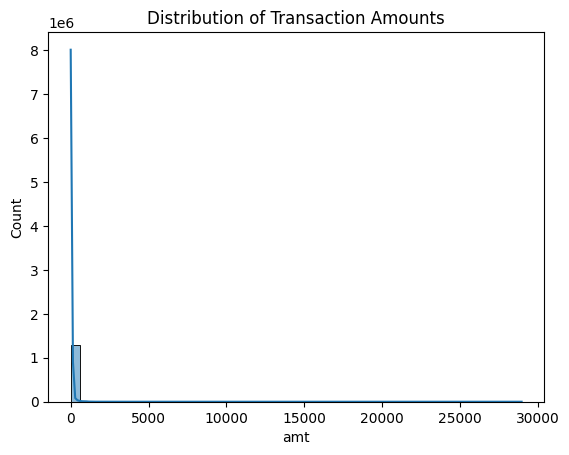

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['amt'], bins=50, kde=True)
plt.title('Distribution of Transaction Amounts')
plt.show()


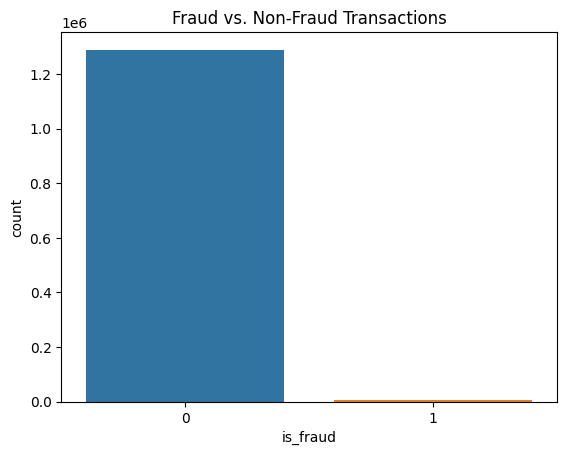

In [16]:
sns.countplot(x='is_fraud', data=df)
plt.title('Fraud vs. Non-Fraud Transactions')
plt.show()


**Feature Selection**

In [17]:
features = ['amt', 'gender', 'city_pop', 'job', 'unix_time', 'merch_lat', 'merch_long', 
            'trans_day', 'trans_month', 'trans_hour', 'trans_day_of_week', 'age', 'distance_from_home']
X = df[features]
y = df['is_fraud']


**Encoding**

In [18]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
X_encoded = encoder.fit_transform(X[['gender', 'job']])
X = X.drop(['gender', 'job'], axis=1)
X = pd.concat([X, pd.DataFrame(X_encoded.toarray(), columns=encoder.get_feature_names_out())], axis=1)


**SPLITING**

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [20]:
train_data = pd.concat([X_train, y_train], axis=1)


In [21]:
fraud = train_data[train_data['is_fraud'] == 1]
non_fraud = train_data[train_data['is_fraud'] == 0]


In [22]:
non_fraud_undersampled = non_fraud.sample(n=len(fraud), random_state=42)
undersampled_data = pd.concat([fraud, non_fraud_undersampled])


In [23]:
X_train_undersampled = undersampled_data.drop('is_fraud', axis=1)
y_train_undersampled = undersampled_data['is_fraud']


**Model**

In [24]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_undersampled, y_train_undersampled)


RandomForestClassifier(random_state=42)

In [25]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

y_pred = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', class_report)
print('ROC-AUC Score:', roc_auc)


Confusion Matrix:
 [[246032  11802]
 [    87   1414]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.98    257834
           1       0.11      0.94      0.19      1501

    accuracy                           0.95    259335
   macro avg       0.55      0.95      0.58    259335
weighted avg       0.99      0.95      0.97    259335

ROC-AUC Score: 0.989562090978006


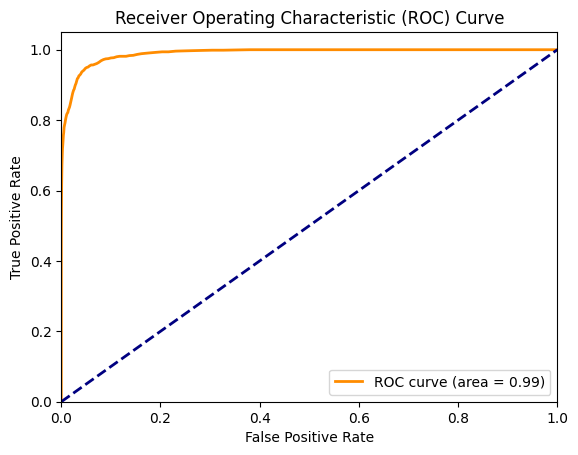

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict the probabilities for the test set
y_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
